## Transfer Learning Models

## Import libraries

In [1]:
import tensorflow as tf 
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0,InceptionV3,VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

## Declare Constants

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

## Load Train Dataset

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    color_mode="rgb"
)

Found 6225 files belonging to 11 classes.


## Load Test Datset

In [4]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/test",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    color_mode="rgb"
)

Found 3187 files belonging to 11 classes.


## Load Validation Dataset

In [5]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/val",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    color_mode="rgb"
)

Found 1092 files belonging to 11 classes.


In [6]:
class_names = train_dataset.class_names
n_classes = len(class_names)

In [7]:
class_names

['animal fish',
 'animal fish bass',
 'fish sea_food black_sea_sprat',
 'fish sea_food gilt_head_bream',
 'fish sea_food hourse_mackerel',
 'fish sea_food red_mullet',
 'fish sea_food red_sea_bream',
 'fish sea_food sea_bass',
 'fish sea_food shrimp',
 'fish sea_food striped_red_mullet',
 'fish sea_food trout']

## Prepare Datasets for Performance

In [8]:

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Load PreTrained Model

### The build_model function:

- Loads a pre-trained CNN model (like MobileNet, ResNet, etc.) without the top classification layer (include_top=False).

- Freezes the base model’s weights (no training).

- Adds custom layers on top:

    - GlobalAveragePooling2D

    - Dropout (to reduce overfitting)

    - Dense softmax output layer for classification.

- Compiles the model with:

    - adam optimizer

    - sparse_categorical_crossentropy loss

    - accuracy metric

### Returns the final compiled model.

In [9]:
def build_model(base_model_fn, model_name):
    print(f"\nBuilding model: {model_name}")
    base_model = base_model_fn(
        input_shape=IMAGE_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze base model

    inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name=model_name)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## List of Pretrained Models to Try

In [10]:

pretrained_models_1 = {
    "MobileNetV2": MobileNetV2,
    "ResNet50": ResNet50,
}

## Train Each Model and Collect Results

In [14]:
IMAGE_SIZE = (224, 224) 
histories = {}
val_accuracies = {}

for name, base_model_fn in pretrained_models_1.items():
    model = build_model(base_model_fn, name)
    
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
    
    print(f"Training {name}...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[early_stop],
        verbose=1
    )

    val_acc = max(history.history["val_accuracy"])
    val_accuracies[name] = val_acc
    histories[name] = history
    print(f"{name} max val_accuracy: {val_acc:.4f}")



Building model: MobileNetV2
Training MobileNetV2...
Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 174s 881ms/step - accuracy: 0.5104 - loss: 1.4242 - val_accuracy: 0.7005 - val_loss: 0.9503
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 162s 832ms/step - accuracy: 0.6890 - loss: 0.9016 - val_accuracy: 0.7628 - val_loss: 0.7648
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 160s 823ms/step - accuracy: 0.7454 - loss: 0.7402 - val_accuracy: 0.7921 - val_loss: 0.6696
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 161s 825ms/step - accuracy: 0.7748 - loss: 0.6626 - val_accuracy: 0.8077 - val_loss: 0.6041
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 162s 832ms/step - accuracy: 0.7913 - loss: 0.6142 - val_accuracy: 0.8242 - val_loss: 0.5705
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 158s 810ms/step - accuracy: 0.8143 - loss: 0.5582 - val_accuracy: 0.8324 - val_loss: 0.5356
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 160s 818ms/step - accuracy: 0.8206 - loss: 0.5366 - val_accuracy: 0.8388 - val_loss: 0.5114
Epoch 8/50
195/195 ━━━━

## Get the best Model

In [15]:
best_model_name_1 = max(val_accuracies, key=val_accuracies.get)
print(f"\n Best model is: {best_model_name_1} with validation accuracy: {val_accuracies[best_model_name_1]:.4f}")


 Best model is: ResNet50 with validation accuracy: 0.9982


## Rebuild the Best Model (for test + fine-tuning)

In [18]:
def build_model(base_model_fn ,model_name, trainable=False):
    print(f"\nBuilding model: {model_name}")
    base_model = base_model_fn(
        input_shape=IMAGE_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = trainable  # Control trainable param

    inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
    x = base_model(inputs, training=not trainable)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name=model_name)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Re-evaluate Best Model on Test Data

In [19]:
# Rebuild best model (frozen)
best_model = build_model(pretrained_models_1[best_model_name_1], best_model_name_1, trainable=False)

# Train briefly (for consistent weights)
best_model.fit(train_dataset, validation_data=val_dataset, epochs=5)

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test Accuracy (frozen): {test_acc:.4f}")


Building model: ResNet50
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.8236 - loss: 0.5874 - val_accuracy: 0.9753 - val_loss: 0.1298
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9738 - loss: 0.1133 - val_accuracy: 0.9853 - val_loss: 0.0633
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9870 - loss: 0.0672 - val_accuracy: 0.9945 - val_loss: 0.0426
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.9899 - loss: 0.0464 - val_accuracy: 0.9973 - val_loss: 0.0337
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9936 - loss: 0.0336 - val_accuracy: 0.9945 - val_loss: 0.0318
100/100 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9937 - loss: 0.0309
Test Accuracy (frozen): 0.9937


## Fine-Tune the Best Model

In [20]:
# Unfreeze top layers for fine-tuning
fine_tune_at = 100

base_model = best_model.layers[1]  # Get base model from sequential
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with low learning rate for fine-tuning
best_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Fine-tune training
fine_tune_history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

# Final test accuracy
test_loss_ft, test_acc_ft = best_model.evaluate(test_dataset)
print(f"Test Accuracy (fine-tuned): {test_acc_ft:.4f}")

Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 629s 3s/step - accuracy: 0.8879 - loss: 0.4240 - val_accuracy: 0.9954 - val_loss: 0.0153
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 614s 3s/step - accuracy: 0.9953 - loss: 0.0230 - val_accuracy: 0.9954 - val_loss: 0.0142
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 615s 3s/step - accuracy: 0.9992 - loss: 0.0106 - val_accuracy: 0.9963 - val_loss: 0.0114
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 615s 3s/step - accuracy: 0.9994 - loss: 0.0065 - val_accuracy: 0.9973 - val_loss: 0.0096
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 632s 3s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9963 - val_loss: 0.0095
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9991 - loss: 0.0063
Test Accuracy (fine-tuned): 0.9991


## Compare Before & After Fine-Tuning

In [21]:
print(f"Before fine-tuning test acc: {test_acc:.4f}")
print(f"After fine-tuning  test acc: {test_acc_ft:.4f}")

Before fine-tuning test acc: 0.9937
After fine-tuning  test acc: 0.9991


## Extract metrics from fine-tuning history

In [22]:
acc = fine_tune_history.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']
epochs_ran = len(acc)

## Accuracy and Validation Plot

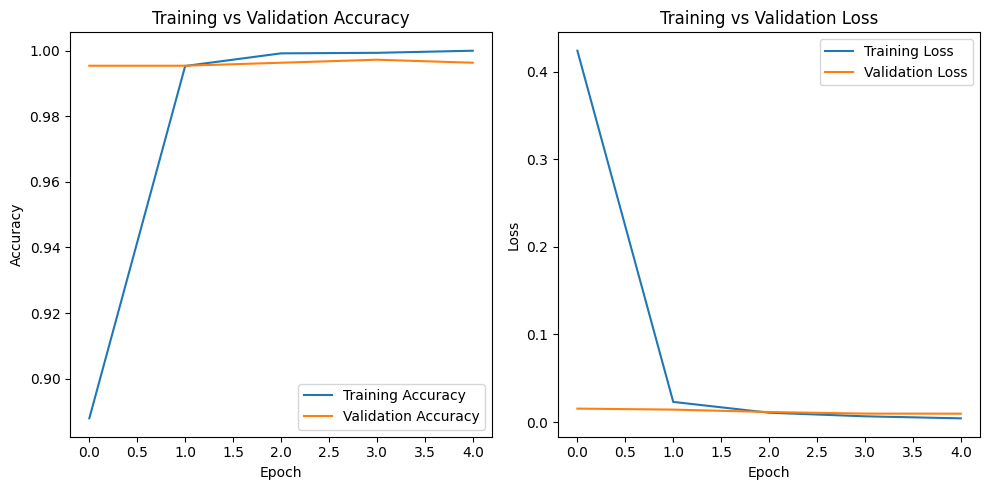

In [23]:
plt.figure(figsize=(10, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs_ran), acc, label='Training Accuracy')
plt.plot(range(epochs_ran), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(loc='lower right')
plt.savefig('../results/metrices/TransferLearning/Training_vs_Validation_Accuracy.png')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs_ran), loss, label='Training Loss')
plt.plot(range(epochs_ran), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend(loc='upper right')
plt.savefig('../results/metrices/TransferLearning/Training_vs_Validation_Loss.png')

plt.tight_layout()
plt.show()

## Making prediction on single image from test dataset

First image to predict:


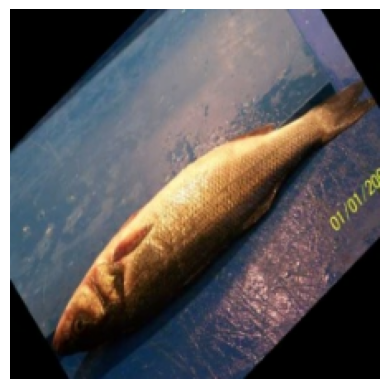

Actual label: fish sea_food sea_bass
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: fish sea_food sea_bass


In [24]:
import numpy as np
# Iterate through one batch from the test dataset
for images_batch, labels_batch in test_dataset.take(1):
    
    # Extract first image and label
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    # Show image
    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis('off')  # Hide axis for cleaner display
    plt.show()

    print("Actual label:", class_names[first_label])

    # Make prediction using fine-tuned best model
    batch_prediction = best_model.predict(images_batch)
    predicted_class = class_names[np.argmax(batch_prediction[0])]

    print("Predicted label:", predicted_class)

## Make Predictions

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array, verbose=0)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

## Display 9 images with predictions

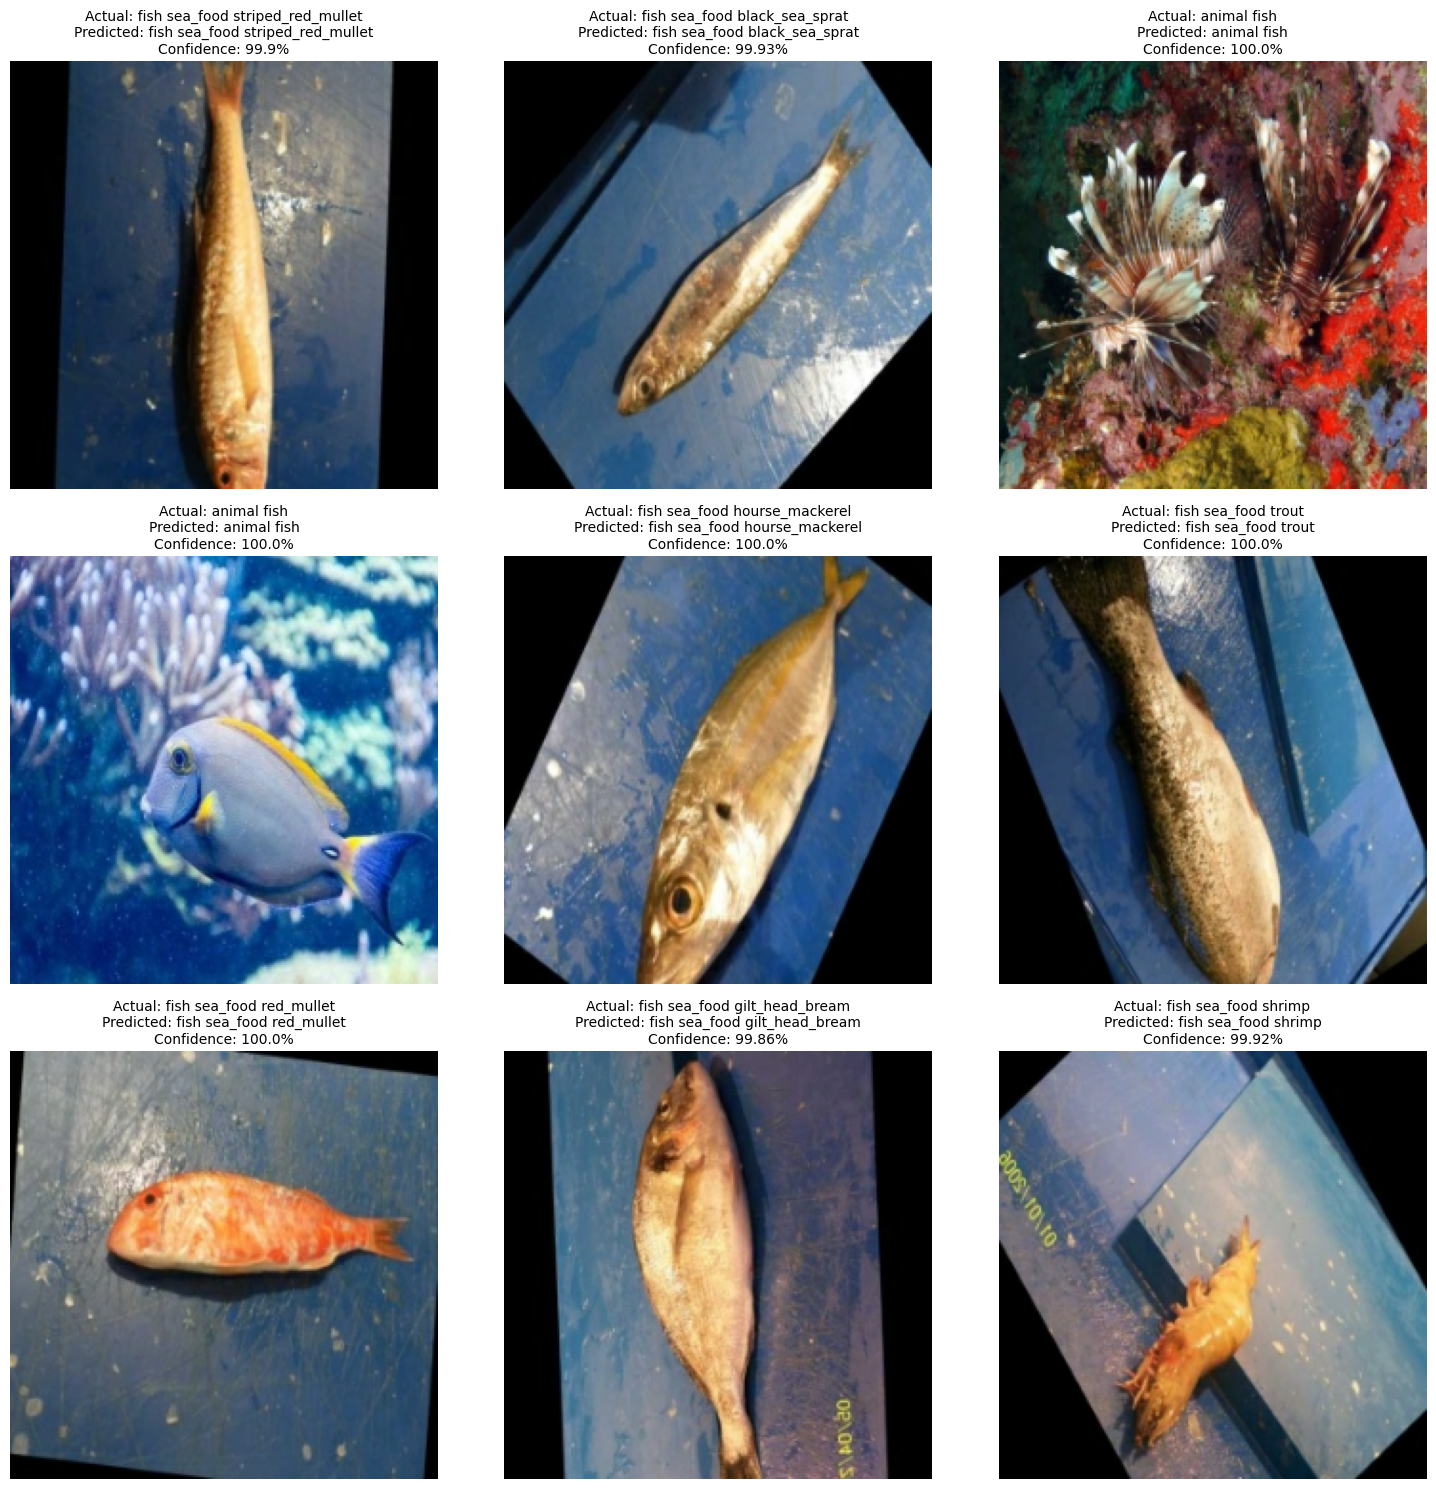

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(best_model, images[i])
        actual_class = class_names[labels[i].numpy()]
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

# Performance Metrices

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9991 - loss: 0.0063
Test Accuracy: 99.91 %

Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       1.00      1.00      1.00       520
                animal fish bass       1.00      0.92      0.96        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.

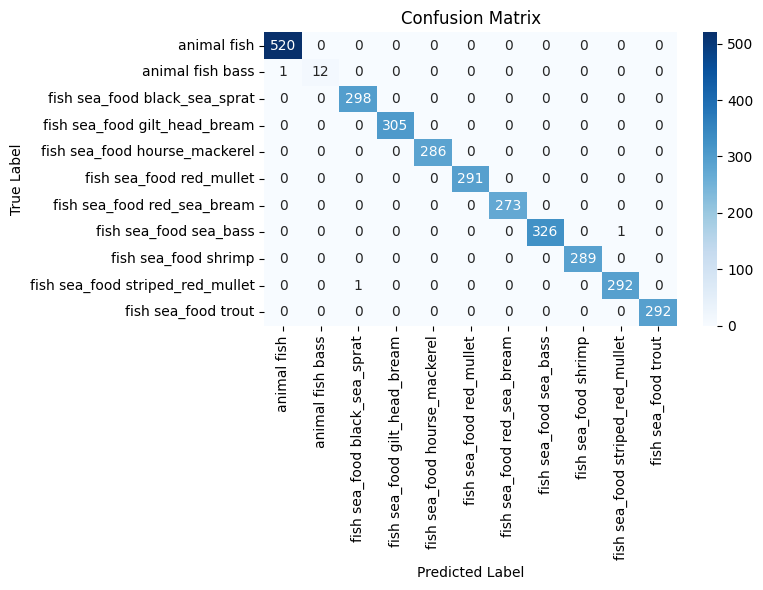

In [28]:
# 1. Evaluate the model
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print("Test Accuracy:", round(test_accuracy * 100, 2), "%")

# 2. Collect predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = best_model.predict(images, verbose=0)
    predicted_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# 3. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Collecting prediction probabilities from best_model on the entire test dataset

In [29]:
y_pred_probs = []

for images, _ in test_dataset:
    probs = best_model.predict(images, verbose=0)
    y_pred_probs.extend(probs)

y_pred_probs = np.array(y_pred_probs)

## ROC-AUC Curve (Multiclass OvR)

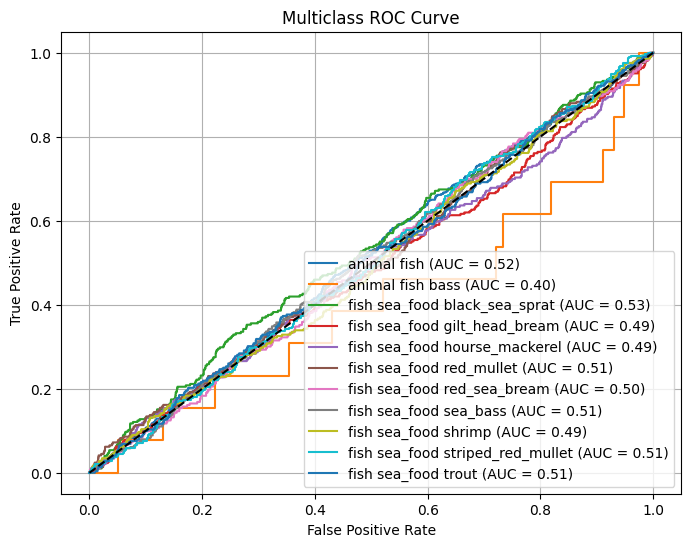

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

n_classes = y_pred_probs.shape[1]
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Save the figure
plt.savefig("../results/metrices/TransferLearning/Transfer_Learning_roc_curve.png")
plt.show()

## Precission-Recall Curve

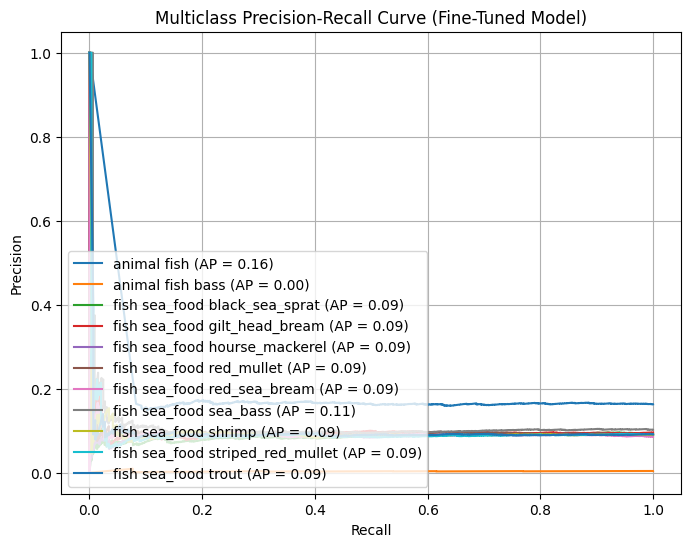

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate prediction probabilities from the fine-tuned best model
y_pred_probs = []

for images, _ in test_dataset:
    probs = best_model.predict(images, verbose=0)
    y_pred_probs.extend(probs)

y_pred_probs = np.array(y_pred_probs)

# 2. Binarize true labels
from sklearn.preprocessing import label_binarize

n_classes = y_pred_probs.shape[1]
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))

# 3. Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve (Fine-Tuned Model)')
plt.legend(loc='lower left')
plt.grid(True)

# 4. Save the plot
plt.savefig("../results/metrices/TransferLearning/Transfer_Learning_precision_recall_curve.png")
plt.show()

## F1-score vs. Threshold

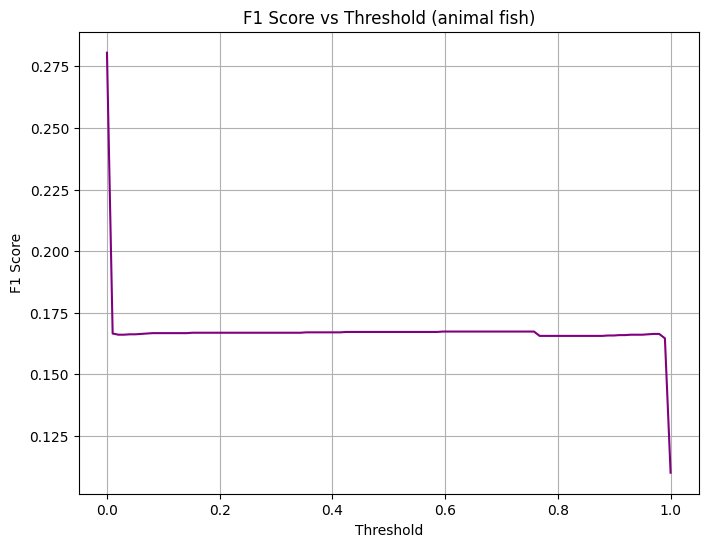

In [32]:
from sklearn.metrics import f1_score

# Select the class index you want to analyze (e.g., 0 for the first class)
class_index = 0
class_name = class_names[class_index]  # Get readable class name

# Thresholds to evaluate
thresholds = np.linspace(0, 1, 100)
f1s = []

# Loop through thresholds to compute F1 scores
for thresh in thresholds:
    preds_thresh = (y_pred_probs[:, class_index] >= thresh).astype(int)
    f1 = f1_score(y_true_binarized[:, class_index], preds_thresh)
    f1s.append(f1)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1s, color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title(f'F1 Score vs Threshold ({class_name})')
plt.grid(True)

# Save and show the plot
plt.savefig(f"../results/metrices/TransferLearning/Transfer_Learning_CNN_f1_score_vs_threshold_{class_name}.png")
plt.show()

## Save Final Best Model

In [33]:
best_model.save(f"../models/{best_model_name_1}_(Transfer_Learning)_fine_tuned_model.keras")
print(f"Model saved as: {best_model_name_1}_(Transfer_Learning)_fine_tuned_model.keras")

Model saved as: ResNet50_(Transfer_Learning)_fine_tuned_model.keras
